In [61]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular
from sklearn.utils import shuffle

In [62]:
df_einfach = pd.read_pickle('einfach.pkl') 
df_schwer = pd.read_pickle('schwer.pkl') 

df_data = pd.concat([df_einfach, df_schwer])
df = shuffle(df_data)

In [63]:
#remove scroll
df_data_without_scroll = df.loc[df["type"] !="scroll"]

In [64]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(df_data_without_scroll, col, max_cat=20):
    if (df_data_without_scroll[col].dtype == "TestEinfach") | (df_data_without_scroll[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

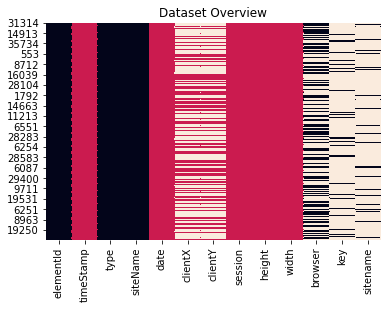

 Categerocial   Numeric   NaN 


In [65]:
dic_cols = {col:utils_recognize_type(df_data_without_scroll, col, max_cat=20) for col in df.columns}
heatmap = df_data_without_scroll.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [66]:
df_data_without_scroll = df_data_without_scroll.set_index("session")
df_data_without_scroll = df_data_without_scroll.rename(columns={"siteName":"Y"})

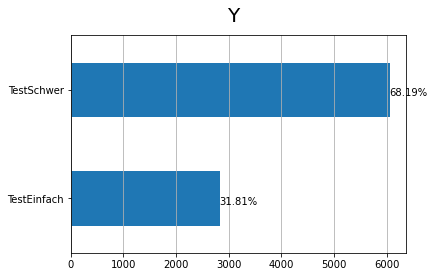

In [67]:
y = "Y"
ax = df_data_without_scroll[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

In [68]:
df_data_without_scroll['timeStamp'] = df_data_without_scroll['timeStamp'].astype(float)

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


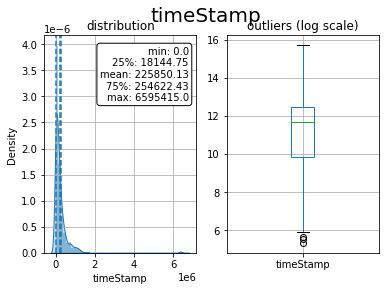

In [69]:
x = "timeStamp"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = df_data_without_scroll[x].fillna(df_data_without_scroll[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df_data_without_scroll[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(df_data_without_scroll[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarnin

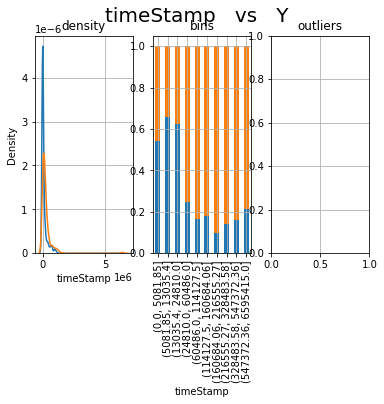

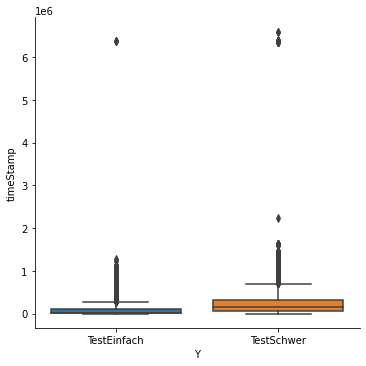

In [70]:
cat, num = "Y", "timeStamp"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df_data_without_scroll[cat].unique():
    sns.distplot(df_data_without_scroll[df_data_without_scroll[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df_data_without_scroll[num], q=np.linspace(0,1,11))
tmp = df_data_without_scroll.groupby([cat, pd.cut(df_data_without_scroll[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df_data_without_scroll[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df_data_without_scroll, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

In [71]:
df_data_without_scroll['timeStamp'] = df_data_without_scroll['timeStamp'].astype(float)
df_data_without_scroll['clientX'] = df_data_without_scroll['clientX'].astype(float)
df_data_without_scroll['clientY'] = df_data_without_scroll['clientX'].astype(float)
df_data_without_scroll['height'] = df_data_without_scroll['height'].astype(float)

df_data_without_scroll['real_date'] = df_data_without_scroll['date'].astype('datetime64[ns]')
df_data_without_scroll['real_date'] = (df_data_without_scroll['real_date'] - df_data_without_scroll['real_date'].min())  / np.timedelta64(1,'D')

In [72]:
# ## Create new column
# df_data_without_scroll["Cabin_section"] = df_data_without_scroll["Cabin"].apply(lambda x: str(x)[0])
# ## Plot contingency table
# cont_table = pd.crosstab(index=dtf["Cabin_section"], 
#              columns=dtf["Pclass"], values=dtf["Y"], aggfunc="sum")
# sns.heatmap(cont_table, annot=True, cmap="YlGnBu", fmt='.0f',
#             linewidths=.5).set_title( 
#             'Cabin_section vs Pclass (filter: Y)' )

In [78]:
df_data_without_scroll = df_data_without_scroll.replace('TestEinfach', 0)
df_data_without_scroll = df_data_without_scroll.replace('TestSchwer', 1)

In [79]:
#wuhu split the data 
## split data
dtf_train, dtf_test = model_selection.train_test_split(df_data_without_scroll, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (6217, 12) | X_test shape: (2665, 12)
y_train mean: 0.68 | y_test mean: 0.68
13 features: ['elementId', 'timeStamp', 'type', 'date', 'clientX', 'clientY', 'height', 'width', 'browser', 'key', 'sitename', 'real_date']


In [80]:
dtf_train["clientY"] = dtf_train["clientY"].fillna(dtf_train["clientY"].mean())
dtf_train["clientX"] = dtf_train["clientX"].fillna(dtf_train["clientX"].mean())

<ipython-input-80-51323b7df5aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["clientY"] = dtf_train["clientY"].fillna(dtf_train["clientY"].mean())
<ipython-input-80-51323b7df5aa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_train["clientX"] = dtf_train["clientX"].fillna(dtf_train["clientX"].mean())


In [85]:
## create dummy
dummy = pd.get_dummies(dtf_train["type"], 
                       prefix="type",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy], axis=1)
## drop the original categorical column
dtf = dtf_train.drop("type", axis=1)

## create dummy
dummy2 = pd.get_dummies(dtf_train["elementId"], 
                       prefix="elementId",drop_first=True)
dtf_train= pd.concat([dtf_train, dummy2], axis=1)
## drop the original categorical column
dtf = dtf_train.drop("elementId", axis=1)

In [86]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
dtf_scaled["Y"] = dtf_train["Y"]
dtf_scaled.head()

ValueError: could not convert string to float: 'nextButton'